Data: http://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/vowel/

https://sci2s.ugr.es/keel/dataset.php?cod=113

* Thinking of a problem that's interesting for you and finding a dataset for that
* Describing this problem and explaining how a model could be used
* Preparing the data and doing EDA, analyzing important features
* Training multiple models, tuning their performance and selecting the best model
* Exporting the notebook into a script
* Putting your model into a web service and deploying it locally with docker
* Bonus points for deploying the service to the cloud

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option('display.max_rows', 200)
from statistics import mean


In [153]:
df = pd.read_csv('vowels_data.csv')
df

,train_test,speaker,sex,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,vowel
0,0,0,0,-3.639,0.418,-0.670,1.779,-0.168,1.627,-0.388,0.529,-0.874,-0.814,0
1,0,0,0,-3.327,0.496,-0.694,1.365,-0.265,1.933,-0.363,0.510,-0.621,-0.488,1
2,0,0,0,-2.120,0.894,-1.576,0.147,-0.707,1.559,-0.579,0.676,-0.809,-0.049,2
3,0,0,0,-2.287,1.809,-1.498,1.012,-1.053,1.060,-0.567,0.235,-0.091,-0.795,3
4,0,0,0,-2.598,1.938,-0.846,1.062,-1.633,0.764,0.394,-0.150,0.277,-0.396,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,1,14,1,-3.239,3.083,-1.427,-0.202,-0.282,1.421,0.576,0.068,-0.914,0.147,6
986,1,14,1,-3.753,3.605,-0.899,-0.747,-0.401,1.765,0.620,0.754,-0.835,-0.301,7
987,1,14,1,-3.980,2.459,0.068,0.023,0.237,1.029,-0.189,0.521,-0.773,-0.500,8
988,1,14,1,-4.264,2.925,0.065,0.794,0.323,0.515,-1.282,-0.140,-0.863,-0.390,9


In [181]:
df.drop(columns = "train_test", inplace = True)

In [5]:
df_test = df[df.speaker.isin([10, 11, 13, 14])]  # Two male and two female in df_test

In [6]:
df_train = df[df.speaker.isin([0,1,2,3,4,5,6,7,8,9,12])]
df_train = df_train.sample(frac=1).reset_index(drop=True)

In [7]:
df_train.head()

,speaker,sex,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,vowel
0,12,1,-3.439,1.007,0.020,1.491,0.777,0.257,-0.777,-0.282,-0.707,0.746,1
1,9,0,-4.074,4.187,-0.555,0.052,-1.603,0.730,-0.061,0.981,0.249,-0.250,7
2,9,0,-3.756,2.204,-0.716,0.529,-0.284,1.121,0.022,0.127,-0.782,-0.394,10
3,7,1,-5.105,1.968,1.140,1.719,-0.443,-0.432,-0.969,-0.173,0.551,0.176,0
4,12,1,-2.027,2.157,-0.297,-0.211,-0.266,0.086,-0.176,-0.179,-0.283,0.292,3


In [8]:
df_train.dtypes

speaker      int64
sex          int64
f0         float64
f1         float64
f2         float64
f3         float64
f4         float64
f5         float64
f6         float64
f7         float64
f8         float64
f9         float64
vowel        int64
dtype: object

It's tricky to know how to split the data for train/val/test. Although I have 990 rows of data, they are only spoken by 15 people, and it is reasonable to think that the person speaking is likely to have a significant impact on the data.

If I were to split the 990 rows randomly, I would have data leakage from the test data into the training data, since some of the training data would come from the same people who also produced test data.

Therefore I decided to split off the test data according to people. I chose two male and two female speakers to constitute the test data.

I considered whether or not I should take a similar approach for the validation data. In the end I decided to use a manual cross-validation, where I held back one person from the training data each time to be used for validation, and then took the mean of the evaluation metrics.

## Missing Values

In [9]:
df_train.isnull().sum()

speaker    0
sex        0
f0         0
f1         0
f2         0
f3         0
f4         0
f5         0
f6         0
f7         0
f8         0
f9         0
vowel      0
dtype: int64

## Exploration of features

<AxesSubplot:>

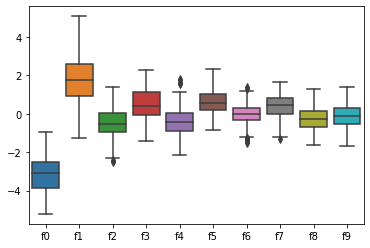

In [10]:
sns.boxplot(data = df_train[['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9']])

We need to shuffle the rows, because they're currently in speaker and vowel order.

## Build and test some initial models

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

In [43]:
def evaluate_model(model, df_train = df_train):
    speakers = df_train['speaker'].unique()
    scores = []
    accuracy = []
    for speaker in speakers:
        df_train = df_train.copy()
        X_train = df_train[df_train['speaker'] != speaker]
        X_val = df_train[df_train['speaker'] == speaker]
        y_train = df_train.loc[df_train['speaker'] != speaker]['vowel']
        y_val = df_train.loc[df_train['speaker'] == speaker]['vowel']
        model.fit(X_train.loc[:, X_train.columns != 'vowel'], y_train)
        y_preds = model.predict_proba(X_val.loc[:, X_val.columns != 'vowel'])
        scores.append(roc_auc_score(y_val, y_preds, multi_class='ovo'))
#     print(f'Scores: {scores}\nMean: {mean(scores)}')
    return mean(scores)

In [13]:
lr = LogisticRegression(multi_class="multinomial", solver='saga')
print(f'AUC: {evaluate_model(lr)}')

/home/mark/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/mark/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/mark/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/mark/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/home/mark/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The m

AUC: (0.8973599632690542, 0)


In [45]:
rf = RandomForestClassifier()
print(f'AUC: {evaluate_model(rf)}')

AUC: 0.9470844811753902


In [46]:
gb = GradientBoostingClassifier()
print(f'AUC: {evaluate_model(gb)}')

AUC: 0.8933884297520661


## Tuning Hyperparameters

### Random Forest

In [810]:
n_estimators_list = [25, 50, 100, 200, 400, 800, 1600]

In [809]:
for n in n_estimators_list:
    rf = RandomForestClassifier(n_estimators=n)
    print(f'n_esimators: {n} \t AUC: {evaluate_model(rf)}')

n_esimators: 25, 	 AUC: 0.9179866850321396
n_esimators: 50, 	 AUC: 0.9319214876033058
n_esimators: 100, 	 AUC: 0.9462350780532599


In [815]:
max_depth_list = [10, 15, 20, 30, 50]

In [816]:
for m in max_depth_list:
    rf = RandomForestClassifier(n_estimators=400, max_depth=m)
    print(f'max_depth: {m} \t AUC: {evaluate_model(rf)}')

max_depth: 10 	 AUC: 0.948014233241506
max_depth: 15 	 AUC: 0.951848025711662
max_depth: 20 	 AUC: 0.9483815426997245
max_depth: 30 	 AUC: 0.9495867768595042
max_depth: 50 	 AUC: 0.951320018365473


In [ ]:
for m in max_depth_list:
    rf = RandomForestClassifier(n_estimators=400, max_depth=15)
    print(f'max_depth: {m} \t AUC: {evaluate_model(rf)}')

## Test Example

In [179]:
vowel = {'speaker': 16, 'sex': [1], 'f0': [0], 'f1': [0], 'f2': [0], 'f3': [0], 'f4': [0], 'f5': [0], 'f6': [0], 'f7': [0], 'f8':[0], 'f9':[0]}
vowel_df = pd.DataFrame.from_dict(vowel)

df_test = df_test.loc[:, df_test.columns != 'vowel']
example_1 = df_test.iloc[[1,]]
example_1 = example_1.to_dict()
example_1

{'speaker': {661: 10},
 'sex': {661: 0},
 'f0': {661: -2.966},
 'f1': {661: 0.659},
 'f2': {661: -1.057},
 'f3': {661: 1.36},
 'f4': {661: 0.152},
 'f5': {661: 1.435},
 'f6': {661: 0.197},
 'f7': {661: 0.926},
 'f8': {661: -0.45},
 'f9': {661: -0.637}}

In [118]:
rf.predict(vowel_df)[0]

2

In [84]:
rf.predict(df_test.loc[:, df_test.columns != 'vowel'])

array([ 0,  2,  5,  3,  4,  4,  6,  7,  8,  9, 10,  0,  2,  5,  5,  6,  4,
        6,  7,  8,  9, 10,  0,  2,  5,  3,  4,  4,  6,  7,  8,  9, 10,  0,
        2,  5,  3,  4,  5,  6,  7,  8,  9, 10,  0,  0,  2,  5,  6,  5,  4,
        7,  8,  9, 10,  0,  0, 10,  5,  4,  5,  4,  7,  8,  9, 10,  0,  2,
        3,  3,  5,  5,  6,  8,  8,  1, 10,  0,  2,  2,  3,  5,  5,  6,  8,
        7,  1, 10,  0,  2,  2,  3,  5,  5,  6,  8,  8,  1, 10,  0,  2,  2,
        3,  5,  5,  6,  8,  8,  1, 10,  0,  2,  2,  3,  5, 10,  6,  8,  8,
        1, 10,  0,  2,  2,  3,  5, 10,  6,  8,  8,  9, 10,  1,  1,  2,  5,
        4, 10,  8,  8, 10,  1,  1,  0,  1,  2,  5,  4, 10,  8,  8, 10,  1,
       10,  0,  1,  2,  5,  4, 10,  8,  8, 10,  1, 10,  0,  1,  2,  5,  4,
       10,  8,  8, 10,  1, 10,  0,  1,  6,  5,  4, 10,  8,  8, 10,  1, 10,
        0,  1,  2,  5,  4, 10,  8,  8, 10,  1, 10,  1,  1,  2,  2,  4,  4,
        6,  7,  8,  1, 10,  1,  1,  2,  5,  4,  5,  6,  7,  8, 10, 10,  0,
        1,  1,  5,  4,  5

In [85]:
df_test.loc[:, df_test.columns != 'vowel']

,speaker,sex,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9
660,10,0,-4.066,0.398,-0.382,1.679,0.121,1.617,0.504,-0.315,-0.226,-0.873
661,10,0,-2.966,0.659,-1.057,1.360,0.152,1.435,0.197,0.926,-0.450,-0.637
662,10,0,-2.695,1.119,-0.986,0.172,0.499,0.372,0.088,0.630,-0.721,-0.256
663,10,0,-2.482,1.896,-1.289,0.112,0.285,0.096,0.022,0.832,-0.333,-0.764
664,10,0,-2.742,2.729,-0.129,-0.490,-0.573,0.868,0.070,0.771,0.053,-0.939
...,...,...,...,...,...,...,...,...,...,...,...,...
985,14,1,-3.239,3.083,-1.427,-0.202,-0.282,1.421,0.576,0.068,-0.914,0.147
986,14,1,-3.753,3.605,-0.899,-0.747,-0.401,1.765,0.620,0.754,-0.835,-0.301
987,14,1,-3.980,2.459,0.068,0.023,0.237,1.029,-0.189,0.521,-0.773,-0.500
988,14,1,-4.264,2.925,0.065,0.794,0.323,0.515,-1.282,-0.140,-0.863,-0.390


## Exporting the Model

In [108]:
model = RandomForestClassifier(n_estimators=400, max_depth=15)
model.fit(df_train.loc[:, df_train.columns != 'vowel'], df_train['vowel'])

RandomForestClassifier(max_depth=15, n_estimators=400)

In [109]:
import pickle 

with open('vowel-model.bin', 'wb') as f_out:
    pickle.dump((model), f_out)

In [180]:
import requests
url = 'http://localhost:9696/predict'
response = requests.post(url, json=example_1)
result = response.json()
result

{'Prediction': 2}